# Test notebook for pastas with Pest Solver

## Packages

In [1]:
from pathlib import Path

import pyemu
import pandas as pd
import matplotlib.pyplot as plt

import pastas as ps
import pastas_plugins.pest as psp

if "b" not in ps.__version__:
    # https://github.com/pastas/pastas/pull/796 is required
    raise Exception("Please run Pastas on the dev branch")

%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

## Create Model

In [3]:
ml = ps.Model(head)
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)

ml.add_stressmodel(sm)

## Solve with SciPy Least Squares

Fit report LeastSquares           Fit Statistics
nfev    24                     EVP         88.65
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1229.99
tmax    2015-06-28 00:00:00    BIC      -1218.96
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
               optimal     initial  vary
pex_A       850.877884  215.674528  True
pex_a       177.192197   10.000000  True
constant_d   27.508810   27.902000  True


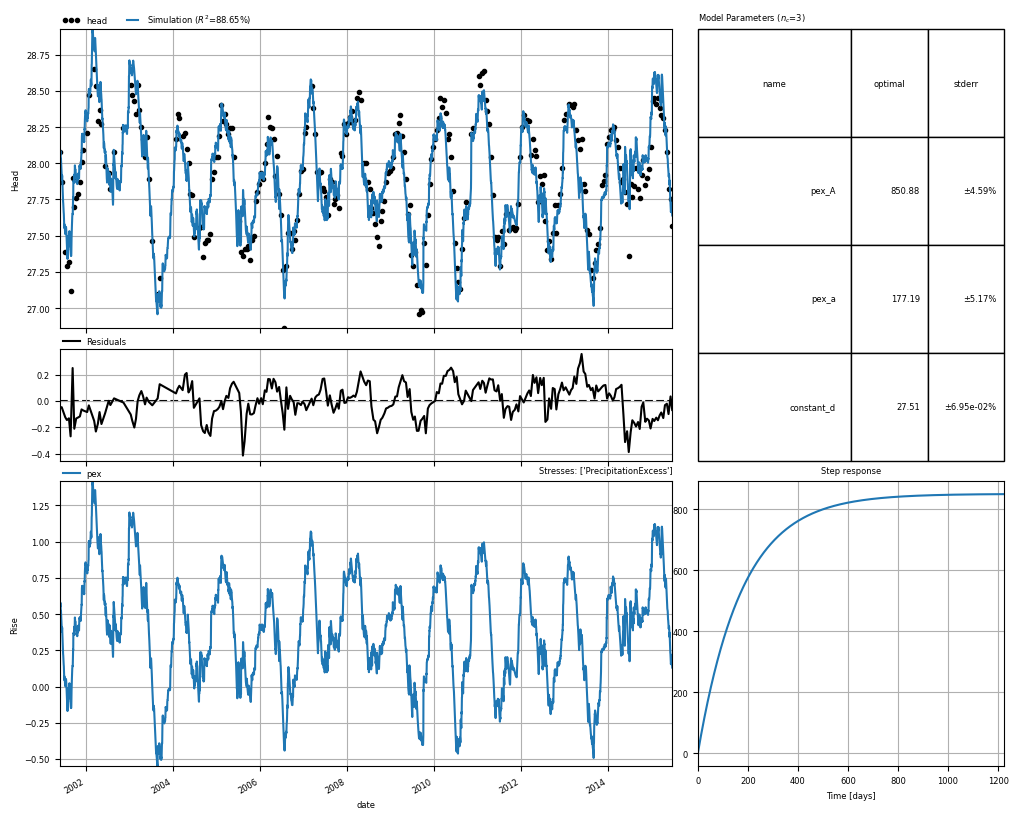

In [4]:
ml_ls = ml.copy()
ml_ls.name = "LeastSquares"
ml_ls.solve(solver=ps.LeastSquares())
_ = ml_ls.plots.results(stderr=True)

## Pest-IES

In [5]:
ml_ies = ml.copy()
ml_ies.name = "PestIES"
solver = psp.PestIesSolver(
    exe_name="bin/pestpp-ies",
    model_ws=Path("pestf_ies/model"),
    temp_ws=Path("pestf_ies/temp"),
    master_ws=Path("pestf_ies/master"),
    noptmax=10,
    port_number=4003,
)
ml_ies.solver = solver
ml_ies.solver.set_model(ml_ies)
ml_ies.solver.run_ensembles(ies_num_reals=101)
ml_ies.solver.nfev = 10
ml_ies.solver.vary = ml_ies.parameters.vary.values

2024-08-19 14:37:36.878884 starting: opening PstFrom.log for logging
2024-08-19 14:37:36.879206 starting PstFrom process
2024-08-19 14:37:36.879282 starting: setting up dirs
2024-08-19 14:37:36.879404 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-08-19 14:37:36.880928 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.001524
2024-08-19 14:37:36.880990 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-08-19 14:37:36.889750 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.008760
2024-08-19 14:37:36.890570 finished: setting up dirs took: 0:00:00.011288
2024-08-19 14:37:36.949175 starting: adding grid type d style parameters for file(s) ['parameters_sel.

In [7]:
ml_ies.solve(run_ensembles=False, report=False) # only sets the optimal parameters and stderr from ensembles run

return type uncaught, losing Ensemble type, returning DataFrame


In [8]:
pst = pyemu.Pst(str(solver.master_ws / "pest.pst"))

pr_oe = pyemu.ObservationEnsemble.from_csv(pst=pst, filename=solver.master_ws / f"pest.0.obs.csv").transpose().set_index(ml.observations().index)
pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst, filename=solver.master_ws / f"pest.{ml_ies.solver.nfev}.obs.csv").transpose().set_index(ml.observations().index)
noise = pyemu.ObservationEnsemble.from_csv(pst=pst, filename=solver.master_ws / "pest.obs+noise.csv")
pt_oe_sim = ml_ies.solver.simulation_ensemble(iteration=ml_ies.solver.nfev) # get simulated ensemble instead of observed ensemble

return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame


In [9]:
(pt_oe - pt_oe_sim.round(4)).dropna(how="all")

real_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,base
2001-05-28,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0001,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,-0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000
2001-06-14,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,-0.0001,0.0000,0.0001,0.0000,0.0000,0.0000
2001-07-14,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,-0.0001,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,-0.0001,0.0000,0.0000,-0.0001,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,-0.0001,0.0001,0.0000,-0.0001,0.0000,0.0001,0.0000,0.0001,0.0000
2001-07-28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,-0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2001-08-14,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000
2001-08-28,0.0001,-0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0

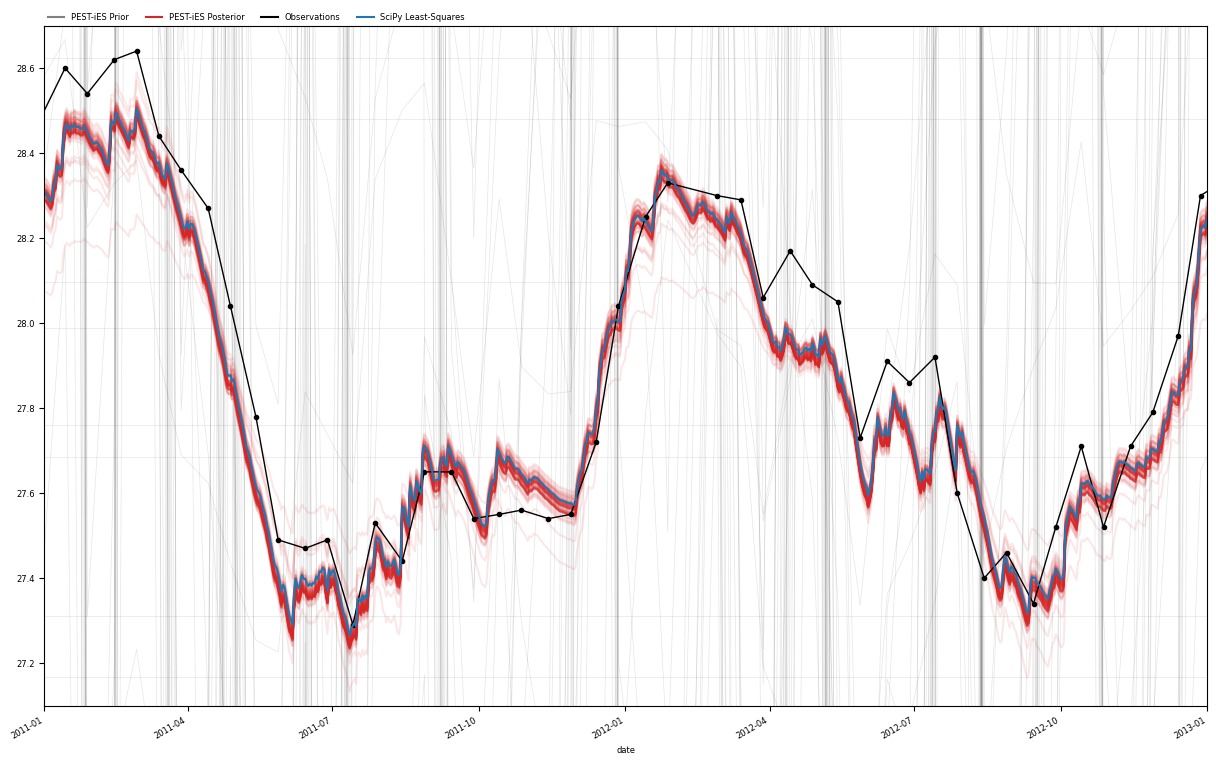

In [10]:
f, ax = plt.subplots(figsize=(15.0, 10.0))
pr_oe.plot(ax=ax, legend=False, linewidth=0.5, color="black", alpha=0.1)
# pt_oe.transpose().set_index(ml.observations().index).plot(ax=ax, legend=False, color="C1", alpha=0.1)
pt_oe_sim.plot(ax=ax, color="C3", alpha=0.1, legend=False)
ml.observations().plot(ax=ax, color="k", linewidth=1, marker=".")
ax.plot([], [], color="grey", alpha=1.0, label="PEST-iES Prior")
ax.plot([], [], color="C3", alpha=1.0, label="PEST-iES Posterior")
ax.plot([], [], color="k", alpha=1.0, label="Observations")
ml_ls.simulate().plot(ax=ax, color="C0", linestyle="-", label="SciPy Least-Squares")
# ax.set_ylim(ml.observations().min(), ml.observations().max())
ax.set_xlim(pd.Timestamp('2011'), pd.Timestamp("2013"))
ax.set_ylim(27.1, 28.7)
ax.grid(False)
labels, handles = ax.get_legend_handles_labels()
ax.legend(labels[-4:], handles[-4:], loc=(0,1), ncol=4, frameon=False)
# f.savefig("pest-ies-obs-ensemble.png", dpi=300, bbox_inches="tight")

# Compare

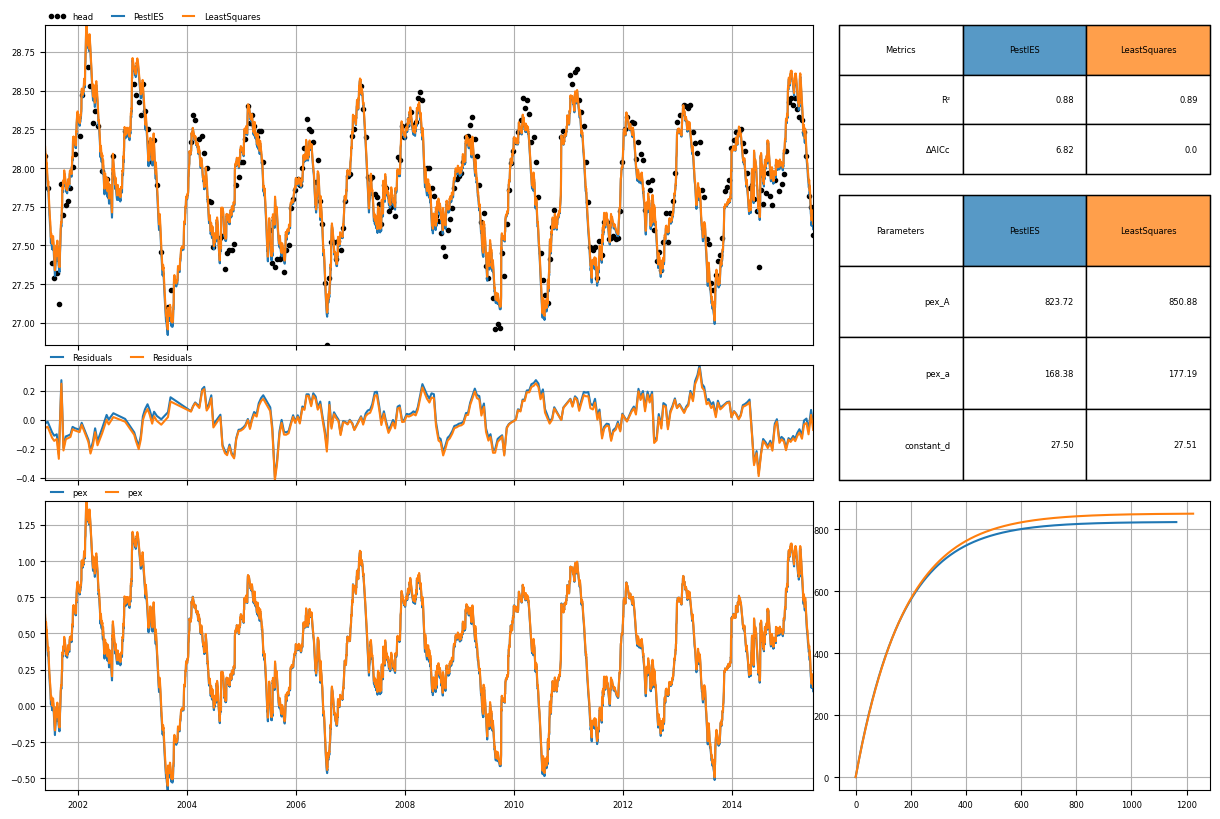

In [11]:
ps.plots.compare([ml_ies, ml_ls], figsize=(12.0, 8.0));

In [12]:
pd.concat([ml_ies.stats.summary(), ml_ls.stats.summary()], axis=1, keys=[ml_ies.name, ml_ls.name]).drop("rmsn")

,PestIES,LeastSquares
,Value,Value
Statistic,,
rmse,0.128897,0.127439
sse,4.984308,4.872243
mae,0.104514,0.103322
nse,0.883842,0.886453
evp,88.585393,88.645332
rsq,0.883842,0.886453
kge,0.921418,0.916928
bic,-1212.135045,-1218.957099


In [13]:
pd.concat([ml_ies.parameters.loc[:, ["optimal", "stderr"]], ml_ls.parameters.loc[:, ["optimal", "stderr"]]], axis=1, keys=[ml_ies.name, ml_ls.name])

PestIES           LeastSquares           
             optimal    stderr      optimal     stderr
pex_A       823.7240  8.661984   850.877884  39.066280
pex_a       168.3840  2.513524   177.192197   9.168912
constant_d   27.5041  0.004102    27.508810   0.019113

In [14]:
ml_ies.solver.parameter_ensemble(iteration=ml_ies.solver.nfev).transpose()

return type uncaught, losing Ensemble type, returning DataFrame


real_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,base
pname:p_inst:0_ptype:gr_usecol:optimal_pstyle:d_parnames:pex_g,859.8690,805.1220,774.2600,847.1100,860.407,945.3750,846.8650,806.7870,858.9040,861.680,968.6780,830.7990,804.7330,802.1380,808.5050,1454.4200,819.7990,805.3770,856.9680,812.1640,800.8420,784.4860,870.1590,858.8430,805.2430,919.0080,862.0220,810.650,798.5310,797.5880,859.277,1015.570,873.9140,858.4000,842.4470,861.141,833.2420,806.5570,869.0110,859.5580,835.7930,902.6010,852.7570,1234.7500,825.2710,1057.4300,872.7980,827.9510,880.5050,854.7930,799.6670,808.6690,837.7840,859.9730,854.132,851.2110,874.1040,908.128,825.2850,890.4080,891.2330,817.9240,783.2990,854.9060,810.0380,805.3940,802.3020,788.0140,858.0320,819.9090,774.1280,811.6900,808.4750,982.6290,832.1000,783.5480,859.6180,800.4570,852.0530,871.1500,801.227,836.2320,839.1780,849.9820,799.1660,817.7110,859.1410,806.4400,823.7890,867.3290,955.5870,902.6780,810.1610,827.9510,802.0490,829.0630,803.5680,794.9520,807.4430,804.2800,823.7240
pname:p_inst:0_ptype:gr_usecol:optimal_pstyle:d_parnames:pex_a,176.6940,163.6640,161.9560,173.8100,176.808,193.8080,173.7750,164.1920,176.4830,177.077,244.7300,169.8880,163.7690,163.3840,164.5850,263.8230,167.2540,164.3010,176.0430,165.5910,162.8500,161.8070,179.1880,176.4690,163.7980,189.1350,177.1500,165.138,162.2230,162.8410,176.566,245.413,180.1520,176.3700,172.6910,176.961,170.5040,164.1850,178.7910,176.6270,172.0910,188.9010,175.0780,237.2350,168.5310,352.4180,181.3040,169.2010,184.8520,175.5430,162.4900,165.4170,171.8420,176.7160,175.393,175.0080,180.6470,196.095,183.2140,183.4670,188.6520,166.9390,161.6020,175.5690,164.8980,163.8120,163.4810,160.2030,176.2860,167.4730,159.2430,165.3640,164.4740,232.1210,170.2080,161.6880,176.6400,163.7590,174.9160,181.7050,162.995,171.2180,171.7510,174.4400,162.3610,166.9410,176.5360,164.0650,168.1880,179.3410,195.4380,187.2490,166.1980,169.2010,163.4690,169.2680,163.9020,161.5670,164.1930,163.5980,168.3840
pname:p_inst:0_ptype:gr_usecol:optimal_pstyle:d_parnames:constant_d,27.4813,27.5237,27.5446,27.5173,27.481,27.4764,27.4878,27.5245,27.4825,27.481,27.4441,27.5084,27.5113,27.5139,27.5087,27.2171,27.4905,27.5517,27.4854,27.5329,27.5201,27.5214,27.4978,27.4826,27.5221,27.4464,27.4812,27.518,27.5337,27.5152,27.482,27.449,27.5042,27.4833,27.5015,27.481,27.5066,27.5096,27.5127,27.4816,27.5094,27.4953,27.4906,27.3354,27.5097,27.3957,27.5025,27.5154,27.4874,27.4882,27.5458,27.5071,27.5153,27.4812,27.489,27.4665,27.5091,27.482,27.4716,27.4681,27.4868,27.5204,27.5129,27.4881,27.5152,27.5152,27.5126,27.5526,27.4838,27.5346,27.5403,27.5054,27.5187,27.4564,27.5083,27.5215,27.4816,27.5101,27.4915,27.4802,27.519,27.5075,27.4752,27.4937,27.5339,27.5342,27.4821,27.5189,27.5059,27.4821,27.4423,27.4769,27.5185,27.5154,27.5102,27.4926,27.5109,27.5385,27.5225,27.5138,27.5041
